In [57]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
import h5py
import pandas as pd
import seaborn as sns
import ringdown as rd
from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise
from pycbc.inference import io, models
from pycbc.workflow import WorkflowConfigParser
from pycbc import detector
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# Ringdown results

In [60]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [61]:
#result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_fit.nc')
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain

ifos = ['H1', 'L1']
input_path = '../../maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}

In [64]:
T = 0.2
srate = 2048
fit = rd.Fit(model='mchi_aligned')
fit.set_tone_sequence(2)

for s in raw_strain.values():
    fit.add_data(s)

fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
# condition data
fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
# compute autocovariance functions
fit.compute_acfs()

# Using Stan's optimization function

In [ ]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0, cosi_max=-0.99, flat_A=1)
stan_data = fit.model_input
stan_data['only_prior']=0
par = fit._model.optimizing(data=stan_data)

In [43]:
nchain = 2
ndraw = 512
nifo = 0

h_det = result.posterior.h_det[nchain,ndraw,nifo].values
h_det_mode0 = result.posterior.h_det_mode[nchain,ndraw,nifo,0].values
h_det_mode1 = result.posterior.h_det_mode[nchain,ndraw,nifo,1].values

A0 = result.posterior.A[nchain,ndraw,0].values
A1 = result.posterior.A[nchain,ndraw,1].values
phi0 = result.posterior.phi[nchain,ndraw,0].values
phi1 = result.posterior.phi[nchain,ndraw,1].values
chi = result.posterior.chi[nchain,ndraw].values
M = result.posterior.M[nchain,ndraw].values

In [44]:
%matplotlib inline

Text(0, 0.5, 'Strain')

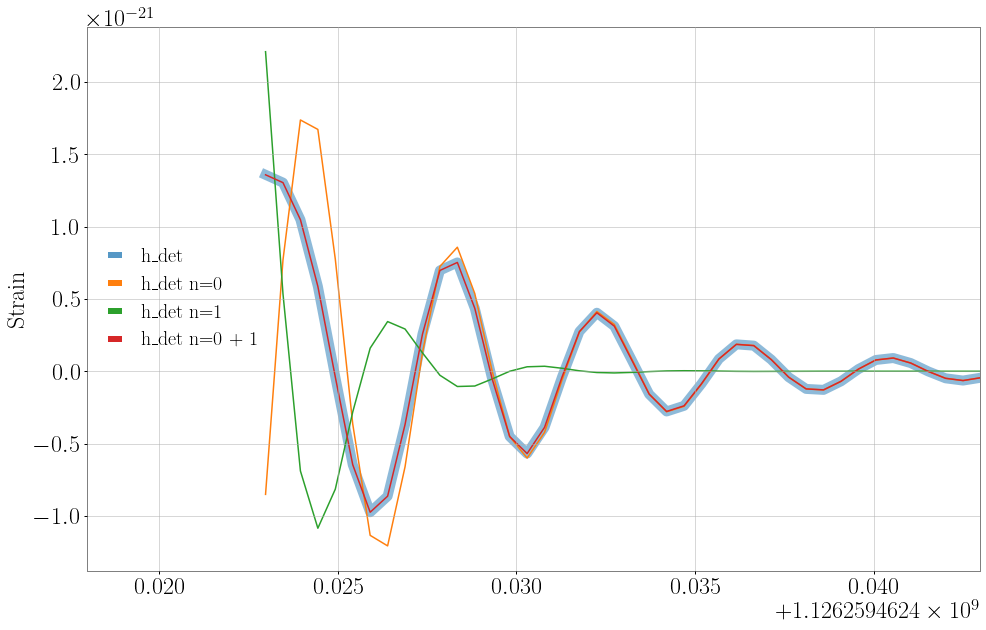

In [45]:
#The 0th element is H1
t = result.constant_data.times[0].values

plt.figure(figsize=[16,10])
plt.plot(t,h_det,lw=10,alpha=0.5,label='h_det')
plt.plot(t,h_det_mode0,label='h_det n=0')
plt.plot(t,h_det_mode1,label='h_det n=1')
plt.plot(t,h_det_mode0+h_det_mode1,label='h_det n=0 + 1')
plt.xlim(t[0]-0.005,t[0]+0.02)
plt.legend()
plt.ylabel('Strain')

# PyRing waveform

In [46]:
input_par = {'data-H1': '', 
             'data-L1': '', 
             'data-V1': '', 
             'ignore-data-filename': 0, 
             'download-data': 1, 
             'datalen-download': 4096.0, 
             'gw-data-find': 0, 
             'gw-data-type-H1': '', 
             'gw-data-type-L1': '', 
             'gw-data-type-V1': '', 
             'tag': 'CLN', 
             'channel-H1': 'GWOSC', 
             'channel-L1': 'GWOSC', 
             'channel-V1': 'GWOSC', 
             'config-file': 'config_gw150914_production.ini', 
             'run-type': 'full', 
             'output': 'GW150914_PROD1_Kerr_221_0M', 
             'run-tag': 'PROD1', 
             'screen-output': 0, 
             'pesummary': 1, 
             'trigtime': 1126259462.423235, 
             'detectors': ['H1', 'L1'], 
             'ref-det': 'H1', 
             'sky-frame': 'equatorial', 
             'acf-H1': '', 
             'acf-L1': '', 
             'acf-V1': '', 
             'psd-H1': '', 
             'psd-L1': '', 
             'psd-V1': '', 
             'signal-chunksize': 8.0, 
             'noise-chunksize': 8.0, 
             'window-onsource': 0, 
             'window': 1, 
             'alpha-window': 0.1, 
             'sampling-rate': 2048, 
             'f-min-bp': 20.0, 
             'f-max-bp': 2038.0, 
             'bandpassing': 1, 
             'fft-acf': 1, 
             'acf-simple-norm': 1, 
             'no-lognorm': 0, 
             'truncate': 1, 
             'analysis-duration': 0.2, 
             'analysis-duration-n': int(0.2*2048),
             'zero-noise': 0, 
             'gaussian-noise': '', 
             'gaussian-noise-seed': -1, 
             'gaussian-noise-white-sigma': 1e-21, 
             'chisquare-computation': 0, 
             'non-stationarity-check': 0, 
             'onsource-ACF': 0, 
             'noise-averaging-method': 'mean', 
             'Dirac-comb': 0, 
             'Zeroing-data': 0, 
             'maxent-psd': '', 
             'PSD-investigation': 0, 
             'injection-parameters': None, 
             'injection-approximant': '', 
             'inject-n-ds-modes': {'t': 1}, 
             'inject-area-quantization': 0, 
             'inject-charge': 0, 
             'injection-scaling': 1.0, 
             'injection-T': 64.0, 
             'template': 'Kerr', 
             'single-mode': None, 
             'n-ds-modes': {'t': 1}, 
             'ds-ordering': 'freq', 
             'kerr-modes': [(2, 2, 2, 0), (2, 2, 2, 1)], 
             'reference-amplitude': 1e-21, 
             'spheroidal': 0, 
             'qnm-fit': 1, 
             'coherent-n': 0, 
             'amp-non-prec-sym': 1, 
             'max-Kerr-amp-ratio': 0.0, 
             'TGR-overtones-ordering': 'Unordered', 
             'domega-tgr-modes': None, 
             'dtau-tgr-modes': None, 
             'area-quantization': 0, 
             'tau-AQ': 0, 
             'prior-reweight': 0, 
             'ParSpec': 0, 
             'ParSpec_Dmax_TGR': 2, 
             'ParSpec_Dmax_charge': 0, 
             'EsGB': 0, 
             'charge': 0, 
             'gr-time-prior': 1, 
             'dist-flat-prior': 0, 
             'ds-amp-flat-prior': 0, 
             'mf-time-prior': 67.92493161247017, 
             'nonref-det': 'L1'}
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**input_par)


Trigtime in H1: 1126259462.423235


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20.0, 2038.0] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Estimating ACF.
Plancherel theorem E(f)/E(t) (expected value: 1) = 1.065045039193097

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20.0, 2038.0] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8
Computing the one-sided PSD with the Welch method and the standard ACF for comparison.
No ACF was passed. Est

In [47]:
prefactor = np.sqrt(16*np.pi/5)
par = {'Mf': M,
 'af': chi,
 'A2220': A0/1e-21*prefactor,
 'A2221': A1/1e-21*prefactor,
 'phi2220': -phi0,
 'phi2221': -phi1}
model.log_likelihood(par)

39298.803051477094

In [48]:
ra = model.fixed_params['ra']
dec = model.fixed_params['dec']
psi = model.fixed_params['psi']
t_start = model.fixed_params['t']
wf_model = model.get_waveform(par)

likelihood.loglikelihood(model,par,wf_model,
                        ra,dec,psi,t_start,
                        model.time_delay,
                        model.ref_det,
                        1,
                        int(4096*0.2),
                        0,
                        0,
                        0)

ValueError: shapes (409,409) and (819,) not aligned: 409 (dim 1) != 819 (dim 0)

Exception ignored in: 'pyRing.likelihood.inner_product'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in dot
ValueError: shapes (409,409) and (819,) not aligned: 409 (dim 1) != 819 (dim 0)


ValueError: shapes (409,409) and (819,) not aligned: 409 (dim 1) != 819 (dim 0)

Exception ignored in: 'pyRing.likelihood.inner_product'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 6, in dot
ValueError: shapes (409,409) and (819,) not aligned: 409 (dim 1) != 819 (dim 0)


39709.64666857826

In [49]:
def damped_sinusoid(A,                     # Amplitude
                    f,                     # Frequency
                    tau,                   # Damping time
                    phi,                   # Phase
                    t0,                    # Start time
                    t  # Time array
                   ):
    n=t.shape[0]
    h=np.zeros(n,dtype='complex')
    omega  = 2.0*np.pi*f
    om_cplx = omega+1j/tau
    t_start_idx  = np.ceil((t0-t[0])/(t[1]-t[0]))
    h[t_start_idx:] = A*np.exp(1j*om_cplx*(t[t_start_idx:]-t0)+1j*phi)
    return h

def yifan_prwaveform(time,Mf,af,a,l=2,m=2,n=0):
    """
        | We employ the conventions of arXiv:gr-qc/0512160 (Eq. 2.9):
        |                            h_s           = Re(sum_{lmn} S_{lmn} h_{lmn})
        |                            h_vx + i h_vy = sum_{lmn} S_{lmn} h_{lmn}
        |                            h_+  + i h_x  = sum_{lmn} S_{lmn} h_{lmn}
        | Non-precessing symmetry implies the property: h_{l,-m} = (-1)**l h^*_{l,m}
        | (see: Blanchet, “Gravitational Radiation from Post-Newtonian Sources and Inspiralling Compact Binaries”).
    """
    qnm = pyRing.waveform.QNM_fit(l,m,n)
    freq=qnm.f(Mf,af)
    tau=qnm.tau(Mf,af)

    h_tmp = damped_sinusoid(1e-21,  freq, tau, 0.0, self.t0, times) * swshs[(2,l, m,n)] * a + \
    damped_sinusoid(1e-21, -freq, tau, 0.0, self.t0, times) * self.swshs[(2,l,-m,n)] * np.conj(a)*(-1)**l
    h_p  = np.real(h_tmp)
    h_c  = np.imag(h_tmp)
       
    return np.array([h_p, h_c])

from lal import ComputeDetAMResponseExtraModes, GreenwichMeanSiderealTime, LIGOTimeGPS
def project(hs,
            hvx,
            hvy,
            hp,
            hc,
            detector,
            ra,
            dec,
            psi,
            tgps):

    #cdef double gmst, fs, fvx, fvy, fp, fc
    gmst   = GreenwichMeanSiderealTime(tgps)
    #The breathing and longitudinal modes act on a L-shaped detector in the same way up to a constant amplitude, 
    # thus we just use one. See Isi-Weinstein, arxiv 1710.03794
    fp, fc, fb, fs, fvx, fvy = ComputeDetAMResponseExtraModes(detector.response, ra, dec, psi, gmst)
    waveform = fs*hs + fvx*hvx + fvy*hvy + fp*hp + fc*hc

    return waveform
def inner_product(C,X):
    return np.dot(X,np.dot(C,X))
def loglikelihood_core(residuals,inverse_covariance,log_normalisation):
    return -0.5*inner_product(inverse_covariance, residuals) + log_normalisation
def pyring_waveform_hphc(model,
                  x, #dict of par
                  waveform_model,
                  ra,
                  dec,
                  psi,
                  t_start,
                  time_delay,
                  ref_det,
                  truncate,
                  duration_n,
                  OnsourceACF  = 0,
                  Dirac_comb   = 0,
                  Zeroing_data = 0):

    wf = {}
    hp={}
    hc={}
    for d in model.detectors.keys():
        dt   = time_delay['{0}_'.format(ref_det)+d]
        tref = LIGOTimeGPS(t_start+dt+model.tevent)
        time_array_raw = model.detectors[d].time - (model.tevent+dt)
        time_array     = time_array_raw[time_array_raw >= t_start][:duration_n]
        wf_model             = waveform_model.waveform(time_array)
        hp[d] = wf_model[3]
        hc[d] = wf_model[4]
    return hp,hc

def pyring_waveform(model,
                  x, #dict of par
                  waveform_model,
                  ra,
                  dec,
                  psi,
                  t_start,
                  time_delay,
                  ref_det,
                  truncate,
                  duration_n,
                  OnsourceACF  = 0,
                  Dirac_comb   = 0,
                  Zeroing_data = 0):

    wf = {}

    for d in model.detectors.keys():
        dt   = time_delay['{0}_'.format(ref_det)+d]
        tref = LIGOTimeGPS(t_start+dt+model.tevent)
        time_array_raw = model.detectors[d].time - (model.tevent+dt)
        time_array     = time_array_raw[time_array_raw >= t_start][:duration_n]
        wf_model             = waveform_model.waveform(time_array)
        hs, hvx, hvy, hp, hc = wf_model[0], wf_model[1], wf_model[2], wf_model[3], wf_model[4]
        wf[d] = project(hs, hvx, hvy, hp, hc, model.detectors[d].lal_detector, ra, dec, psi, tref)
    return wf

def loglikelihood(model,
                  x, #dict of par
                  waveform_model,
                  ra,
                  dec,
                  psi,
                  t_start,
                  time_delay,
                  ref_det,
                  truncate,
                  duration_n):

    logL = 0.0
    for d in model.detectors.keys():

        # Waveform starts at time 0, so we need the 0 to be at model.tevent+dt
        # Sample times for each detector are: d.time-(model.tevent + dt)
        dt   = time_delay['{0}_'.format(ref_det)+d]
        tref = LIGOTimeGPS(t_start+dt+model.tevent)

        if not truncate:
            time_array     = model.detectors[d].time - (model.tevent+dt)
            data           = model.detectors[d].time_series
        else:
            # crop data
            time_array_raw = model.detectors[d].time - (model.tevent+dt)
            time_array     = time_array_raw[time_array_raw >= t_start][:duration_n]
            data           = model.detectors[d].time_series[time_array_raw >= t_start][:duration_n]

        if waveform_model is not None:

            wf_model             = waveform_model.waveform(time_array)
            hs, hvx, hvy, hp, hc = wf_model[0], wf_model[1], wf_model[2], wf_model[3], wf_model[4]
            residuals            = \
               data - project(hs, hvx, hvy, hp, hc, model.detectors[d].lal_detector, ra, dec, psi, tref)
        else:
            residuals = data


        logL += loglikelihood_core(residuals, model.detectors[d].inverse_covariance, \
                                   model.detectors[d].log_normalisation)

    return logL

In [51]:
#model = pyRing.KerrModel(modes=input_par['kerr-modes'],**input_par)
loglikelihood(model,par,wf_model,
                        ra,dec,psi,t_start,
                        model.time_delay,
                        model.ref_det,
                        1,
                        int(2048*0.2))

39298.803051477094

In [52]:
pyring_wf = pyring_waveform(model,par,wf_model,
                        ra,dec,psi,t_start,
                        model.time_delay,
                        model.ref_det,
                        1,
                        int(4096*0.2),
                        0,
                        0,
                        0)

In [53]:
pyring_wf

{'H1': array([ 1.36266921e-21,  1.19187984e-21,  8.25617286e-22, ...,
        -3.84523484e-53, -4.83371884e-53, -3.24297889e-53]),
 'L1': array([-1.01514185e-21, -7.15218295e-22, -2.99669214e-22, ...,
         3.85669407e-53,  3.15936997e-53,  9.94571751e-54])}

In [54]:
%matplotlib inline

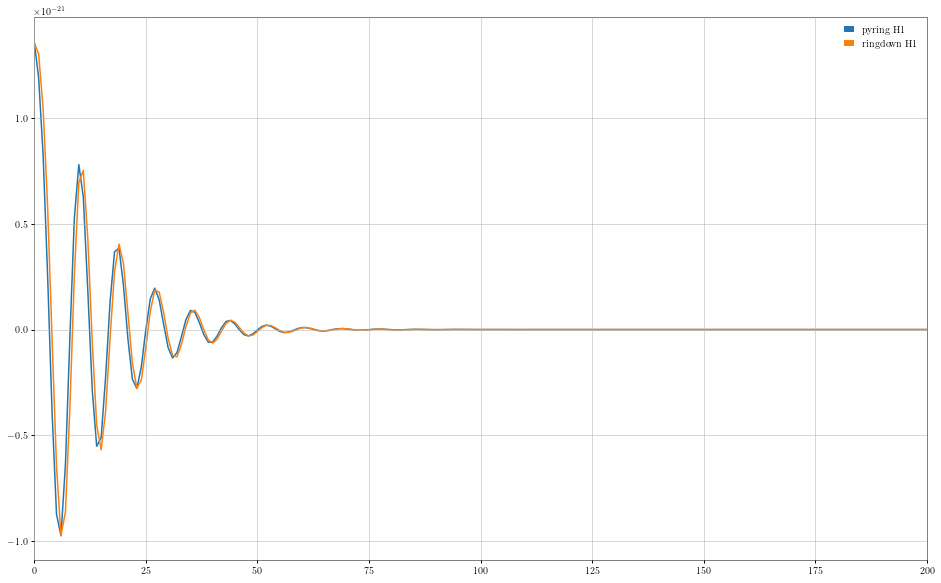

In [56]:
plt.figure(figsize=[16,10])
plt.plot(np.arange(len(pyring_wf['H1'])),pyring_wf['H1'],label='pyring H1')
plt.plot(np.arange(len(h_det)),h_det,label='ringdown H1')
plt.xlim(0,200)
plt.legend(loc='best')

# PyCBC waveform

In [103]:
#using the pyring psd
cp = WorkflowConfigParser(['./inference-GW150914_095045.ini'])
pcmodel = models.read_from_config(cp)

In [104]:
par

{'Mf': array(80.49382284),
 'af': array(0.83745929),
 'A2220': 1.565780010881527,
 'A2221': 1.7503710958283272,
 'phi2220': array(1.24740543),
 'phi2221': array(-1.25384717)}

In [105]:
pcpar ={'final_mass':par['Mf'],
         'final_spin':par['af'],
         'amp220':par['A2220']*1e-21,
         'phi220':par['phi2220'],
         'absamp221':par['A2221']*1e-21,
         'phi221':par['phi2221']}

In [107]:
pcmodel.update(**pcpar)
pcmodel.loglikelihood

-70879720.99245629

In [108]:
# get the matched-filter SNR
print((2*pcmodel.loglr)**0.5)

(2.9033946528387996e-15+47.41603301229801j)


In [116]:
gated_wfs = pcmodel.get_gated_waveforms()
gated_wfs = {ifo: d.to_timeseries() for ifo, d in gated_wfs.items()}

In [124]:
t_gate_end = pcmodel.current_params['t_gate_end']
Det = detector.Detector('H1')
delay = Det.time_delay_from_earth_center(pcmodel.current_params['ra'],
                                         pcmodel.current_params['dec'],
                                         t_gate_end)

th1 = t_gate_end + delay

Text(0, 0.5, 'strain')

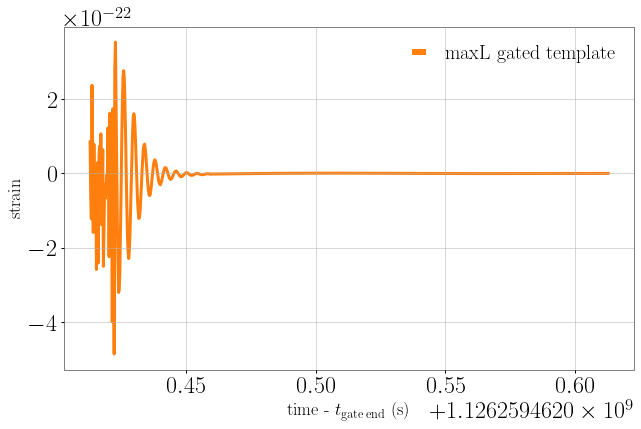

In [128]:
ifo = 'H1'

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the waveform
d = gated_wfs[ifo].time_slice(th1, th1+0.2)
ax.plot(d.sample_times, d, color='C1', lw=3, label='maxL gated template')
ax.legend(loc='best')
ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)', fontsize=18)
ax.set_ylabel('strain', fontsize=18)
#ax.set_xlim(-0.01,0.2)